# **MBTI Personality Predictor using Machine Learning and Natural Language Processing (NLP)**

## **1. Introduction** 

<div style="text-align: justify;"> The Myers-Briggs Type Indicator (MBTI) is widely recognized as a fundamental tool in personality assessment. It classifies individuals into 16 unique personality types, determined by four core dichotomies: 
    <ul>
        <li>introversion/extroversion</li>
        <li>intuition/sensing</li>
        <li>thinking/feeling</li>
        <li>judgment/perception</li>
    </ul>
Despite its widespread usage, the MBTI has faced criticism regarding its reliability and validity in various fields. Nevertheless, its widespread use in various professional settings and interpersonal interactions highlights the importance of analyzing its consequences. <br> <br>
This project investigates the cognitive peculiarities and communicative patterns found in various MBTI personality types, as observed through individuals' most recent 50 tweets. We carefully analyze word choices, sentence structures, and preferred themes among different personality types to discover possible connections between MBTI typologies and communication styles. This endeavor is of great importance in understanding the effectiveness of the MBTI in predicting or categorizing behavioral tendencies. <br> <br>
Recognizing how different personality types are reflected in written communication can have practical implications for customizing marketing strategies, optimizing team dynamics, and improving social interactions. It provides valuable insights for researchers exploring the intricacies of human behavior. By extensively reviewing this dataset, we aim to identify patterns in the writing styles of different MBTI classifications. It will provide a detailed evaluation of the continuing significance of the MBTI in modern psychological discussions. </div>

## **2. Import Libraries** 

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Text preprocessing
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from collections import Counter


# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Feature encoding and extraction
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

# Dimensionality reduction and clustering

# Model selection and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, multilabel_confusion_matrix, classification_report

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

## **3. Load Dataset** 

<div style="text-align: justify;"> The dataset consists of two primary columns: each user's Myers-Briggs Type Indicator (MBTI) classification and a set of 50 textual posts written by the user. The MBTI classification categorizes personality types, while the textual posts are represented as strings, providing insights into users' linguistic patterns and communication styles. </div>

In [2]:
twitter_data = pd.read_csv("dataset/twitter-mbit.csv")
twitter_data.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [3]:
print("The shape of the dataset: ", twitter_data.shape)

The shape of the dataset:  (8675, 2)


In [4]:
twitter_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8675 entries, 0 to 8674
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    8675 non-null   object
 1   posts   8675 non-null   object
dtypes: object(2)
memory usage: 135.7+ KB


<div style="text-align: justify;"> The data contains 8,675 entries and contains two columns. The first column is labeled "type" and includes the Myers-Briggs Type Indicator classifications. The second column, labeled "posts," stores 50 user posts as strings. Both entries are not null and are of the 'object' data type. </div>

Let's identify the distinct values in the 'type' column of the dataset.

In [5]:
twitter_data['type'].value_counts()

INFP    1832
INFJ    1470
INTP    1304
INTJ    1091
ENTP     685
ENFP     675
ISTP     337
ISFP     271
ENTJ     231
ISTJ     205
ENFJ     190
ISFJ     166
ESTP      89
ESFP      48
ESFJ      42
ESTJ      39
Name: type, dtype: int64

<div style="text-align: justify;"> The dataset reveals that the INFP personality type is the most common, occurring 1832 times, followed by INFJ with 1470 occurrences. The types that occur the least frequently are ESFJ, with 42 occurrences, and ESTJ, with 39 occurrences. </div>

In [6]:
twitter_data.groupby(['type']).count()*50

,posts
type,
ENFJ,9500
ENFP,33750
ENTJ,11550
ENTP,34250
ESFJ,2100
ESFP,2400
ESTJ,1950
ESTP,4450
INFJ,73500


The personality type INFP has the highest number of posts, with 91,600, while ESTJ has the lowest number, with 1,950 posts. 

## **4. Exploratory Data Analysis (EDA)** 

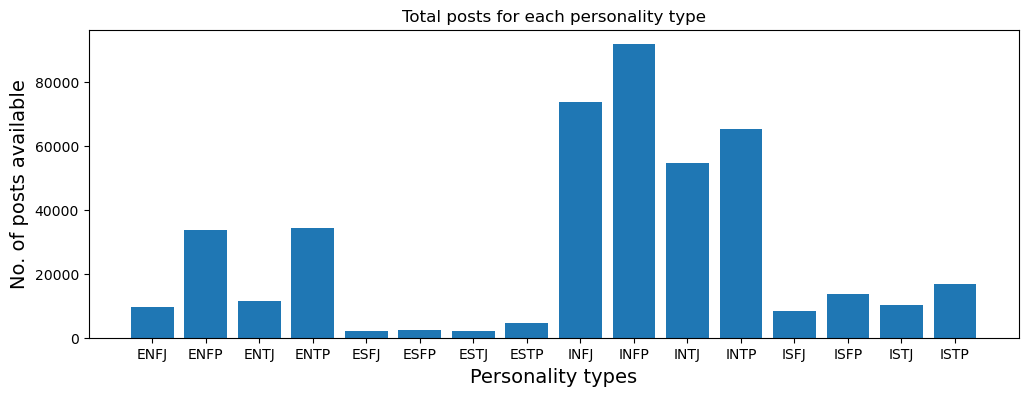

In [7]:
total = twitter_data.groupby(['type']).count()*50
plt.figure(figsize = (12,4));
plt.bar(np.array(total.index), height = total['posts']);
plt.xlabel('Personality types', size = 14);
plt.ylabel('No. of posts available', size = 14);
plt.title('Total posts for each personality type');

<div style="text-align: justify;"> The dataset exhibits a noticeable imbalance among the various classes. Certain personality types possess a significantly greater amount of data compared to others. The most prevalent personality type among users is INFP (Introvert Intuition Feeling Perceiving). <br> <br>
Nevertheless, we reached this conclusion by considering user feedback: Currently, individuals who engage in frequent social media commenting tend to exhibit introverted tendencies, higher perception, and emotional sensitivity. </div>

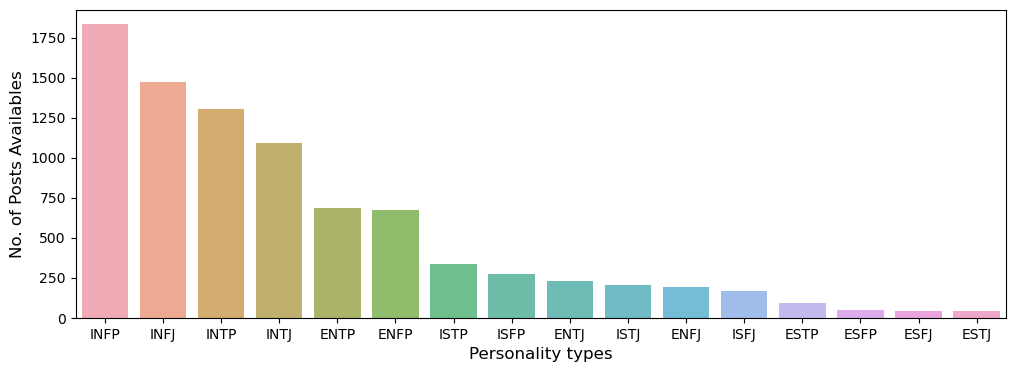

In [8]:
types = twitter_data['type'].value_counts()
plt.figure(figsize = (12,4))
sns.barplot(x = types.index, y = types.values, alpha = 0.8)
plt.xlabel('Personality types', fontsize = 12)
plt.ylabel('No. of Posts Availables', fontsize = 12)
plt.show()

<div style="text-align: justify;"> Considering the few features in the original dataset, we decided to enhance our dataset by creating additional features. This allowed us to explore and analyze the data thoroughly. We thoroughly examined the data to determine the structure of the raw data and the significance of our features in differentiating between the various MBTI personalities. Below are additional plots that illustrate the imbalances in our data. </div>

In [9]:
def calculate_variance_of_word_counts(row):
    """
    Calculate the variance of word counts in each post of a user.

    Parameters:
        row (str): A string containing posts separated by '|||'.

    Returns:
        float: The variance of word counts in the posts.
    """
    word_counts = [len(post.split()) for post in row.split('|||')]
    variance = np.var(word_counts)
    return variance

### **4.1 SwarmPlot** 

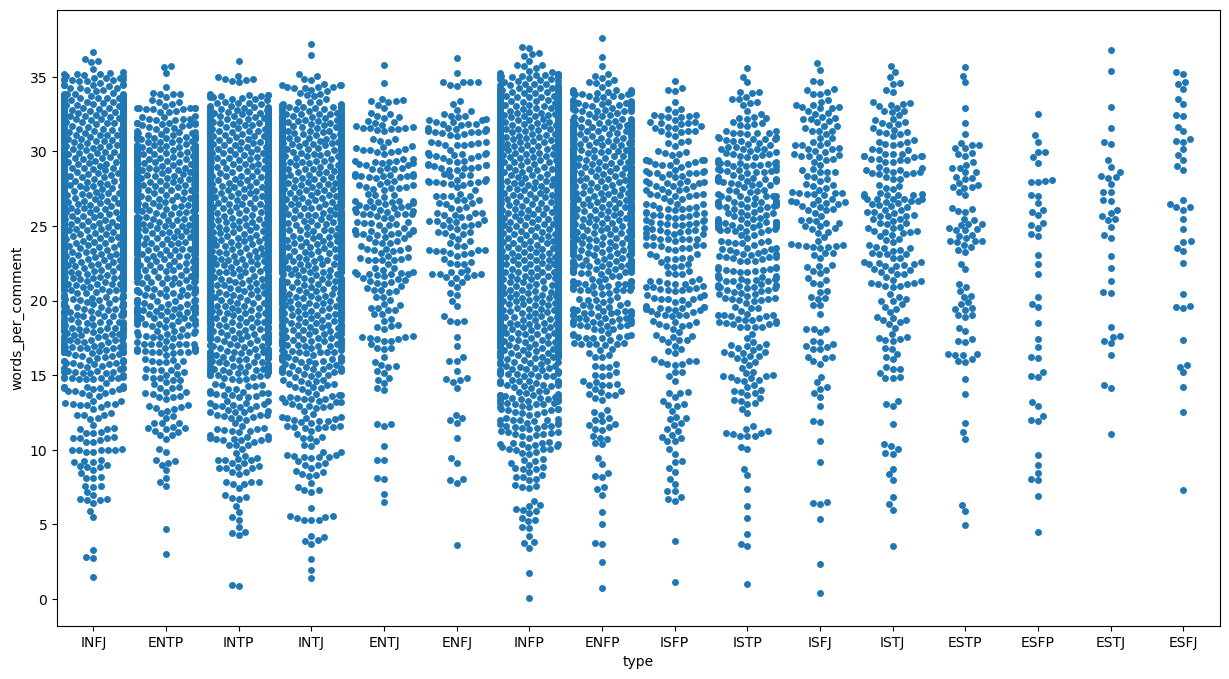

In [10]:
data_copy = twitter_data.copy()

data_copy['words_per_comment']       = data_copy['posts'].apply(lambda x: len(x.split())/50)
data_copy['variance_of_word_counts'] = data_copy['posts'].apply(lambda x: calculate_variance_of_word_counts(x))

plt.figure(figsize=(15,8))
sns.swarmplot(x = "type", y = "words_per_comment", data = data_copy);

This visual representation of a plot indicates the imbalances present. It showcases all observations and features in a total distribution with additional features. Notably, the INFP personality type is observed to have the highest volume of posts, contributing to its cluttered display relative to others.

### **4.2 JointPlot** 

Producing a joint plot to analyze the relationship between the word count in each comment and their variance.

Jointplot efficiently visualizes and analyses the relationship between two variables while providing insights into their distributions on a single plot.

A valuable visualization can be created by including a distribution plot at the top for the column on the x-axis, another distribution plot on the right for the column on the y-axis, and a scatter plot in between to showcase the mutual data distribution for both columns. The region beneath the histogram aids in the computation of the PDF, which refers to the probability density function. The highest point of the curve represents the average of the distribution.

<Figure size 400x300 with 0 Axes>

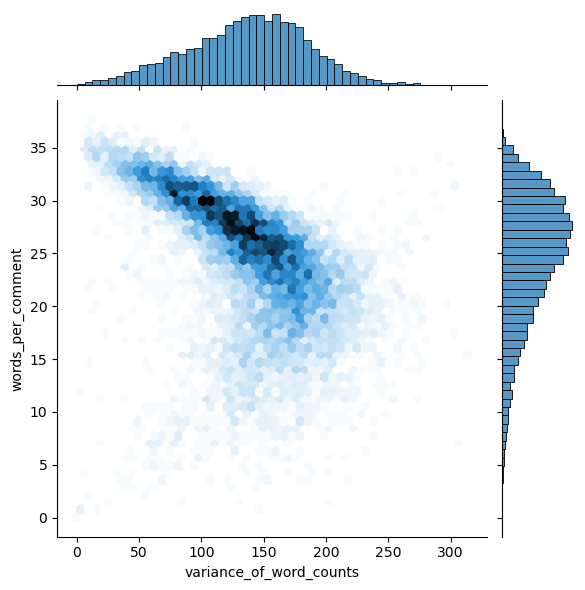

In [11]:
plt.figure(figsize=(4,3))
sns.jointplot(x = "variance_of_word_counts", y = "words_per_comment", data = data_copy, kind = "hex");

The two histograms show the distribution of word counts and their variation in our dataset. The plot shows that most posts contain 100–150 words, and users' comments have 25–30 words. The hexagons with the most points are darker. Moreover, we can observe no correlation between the variance of word count and the number of words per comment.

### **4.3 Distance Plot**

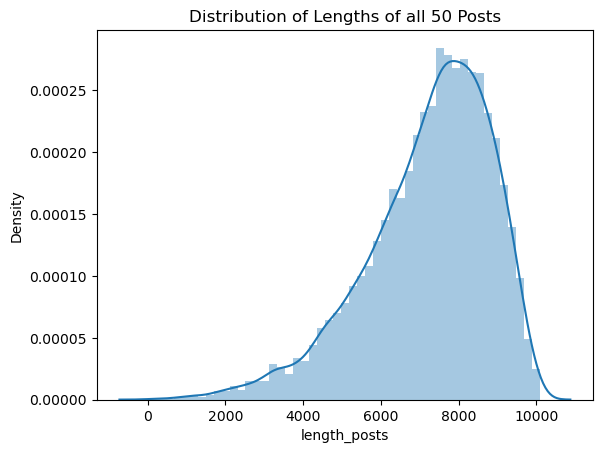

In [12]:
data_copy["length_posts"] = data_copy["posts"].apply(len)
sns.distplot(data_copy["length_posts"]).set_title("Distribution of Lengths of all 50 Posts");

Typically, lengthy posts consist of approximately 7000-9000 words. The line that appears represents the kernel density estimation. It is a standard smoothing problem in which population inferences are formed from a limited data sample. This kernel density estimate is calculated by adding a kernel function to each data point.

### **4.4 Word Clouds**

In [13]:
#Finding the most common words in all posts.
common_words = list(data_copy["posts"].apply(lambda y: y.split()))
common_words = [i for j in common_words for i in j]
Counter(common_words).most_common(40)

[('I', 387957),
 ('to', 290168),
 ('the', 270699),
 ('a', 230918),
 ('and', 219498),
 ('of', 177853),
 ('is', 128804),
 ('you', 128750),
 ('that', 127221),
 ('in', 117263),
 ('my', 104561),
 ('it', 93101),
 ('for', 83057),
 ('have', 79784),
 ('with', 77131),
 ('but', 74729),
 ('be', 69317),
 ('are', 65034),
 ('like', 61390),
 ('not', 59496),
 ('an', 59020),
 ("I'm", 57339),
 ('on', 57062),
 ('was', 56146),
 ('me', 55488),
 ('as', 53310),
 ('this', 52601),
 ('just', 48292),
 ('about', 46305),
 ('think', 46229),
 ('or', 45724),
 ("don't", 44821),
 ('so', 42935),
 ('your', 40918),
 ('do', 40867),
 ('what', 37746),
 ('at', 37566),
 ('can', 37535),
 ('if', 37042),
 ('people', 35546)]

* The majority of the posts consist of common words such as I, I'm, so, me, or, if, and, can, etc. It can be assumed that these words will not contribute valuable information for learning the machine learning model as they primarily consist of stop-words, stem-words, or other meaningless words.
* Therefore, each user's post must undergo comprehensive pre-processing based on their personality type in the provided MBTI dataset.

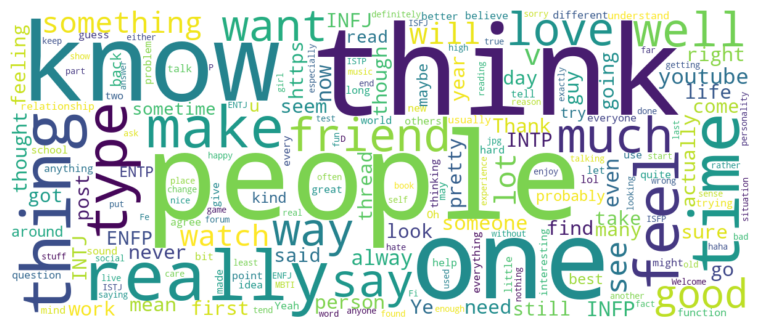

In [14]:
# Generate the WordCloud object with appropriate parameters
wordcloud = WordCloud(width=1200, height=500, 
                      collocations=False, background_color="white", colormap="viridis").generate(" ".join(common_words))

# Plot the WordCloud
plt.figure(figsize=(12,4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Disable axis
plt.show()

We produced 16 Word Clouds for 16 personality groups to showcase the unique language patterns of different MBTI types. The size of each word in the cloud corresponds to its frequency of occurrence in the top posts.

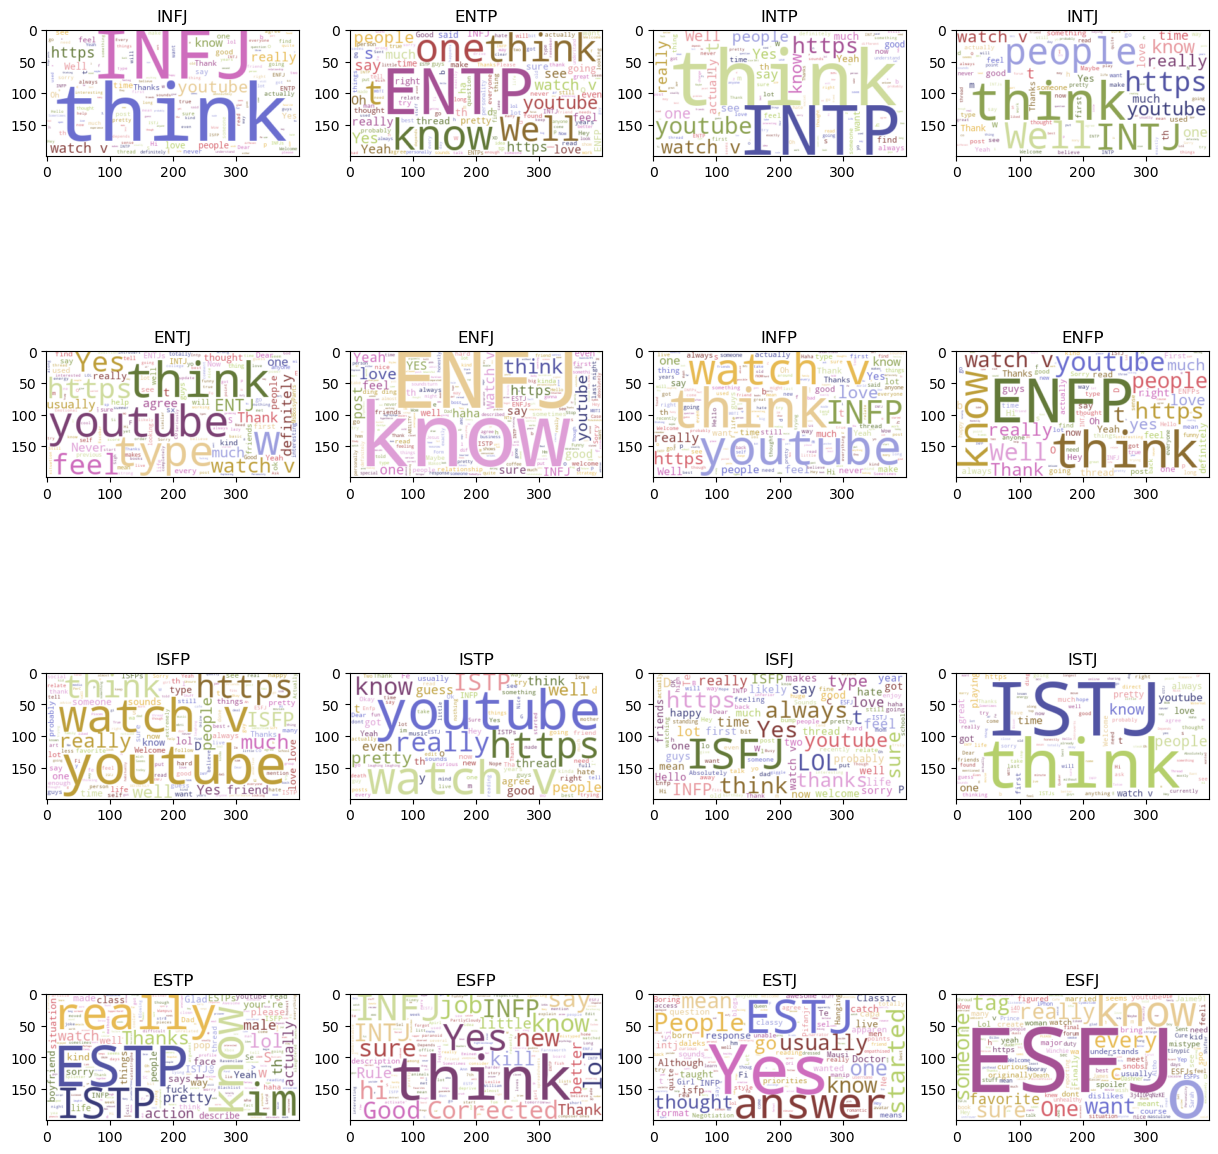

In [15]:
fig, ax = plt.subplots(len(data_copy['type'].unique()), sharex = True, figsize = (15, len(data_copy['type'].unique())))
k = 0
for i in data_copy['type'].unique():
    df = data_copy[data_copy['type'] == i]
    wordcloud = WordCloud(max_words = 1628, relative_scaling = 1, normalize_plurals = False, 
                          background_color="white", colormap="tab20b").generate(df['posts'].to_string())
    plt.subplot(4, 4, k+1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(i)
    ax[k].axis("off")
    k+=1

* We have identified several unnecessary words in the dataset (e.g., ha, ar, Ti, etc.) that must be eliminated.
* However, the word clouds of individual personality types often include the names of MBTI personality types.
* Therefore, cleaning posts by eliminating these MBTI words from each one during the pre-processing stage is essential to improve evaluation results when training the model.

First, it is essential to determine the total number of users and posts in the provided MBTI dataset.

In [16]:
def extract_posts(posts, new_posts):
    for post in posts[1].split("|||"):
        new_posts.append((posts[0], post))

In [19]:
posts = []
data_copy.apply(lambda x: extract_posts(x, posts), axis=1)

print("Number of users:", len(data_copy))
print("Number of posts:", len(posts))
print("First 5 posts:")
print(posts[:5])

Number of users: 8675
Number of posts: 422845
First 5 posts:
[('INFJ', "'http://www.youtube.com/watch?v=qsXHcwe3krw"), ('INFJ', 'http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1rooo1_500.jpg'), ('INFJ', 'enfp and intj moments  https://www.youtube.com/watch?v=iz7lE1g4XM4  sportscenter not top ten plays  https://www.youtube.com/watch?v=uCdfze1etec  pranks'), ('INFJ', 'What has been the most life-changing experience in your life?'), ('INFJ', 'http://www.youtube.com/watch?v=vXZeYwwRDw8   http://www.youtube.com/watch?v=u8ejam5DP3E  On repeat for most of today.')]


* There is a significant number of hyperlinks in these posts.
* It is important to consider that URL links do not offer meaningful insights into a user's personality. Therefore, we must remove these links from our dataset as well.
* The provided sample dataset is not representative of the entire user population. It only includes users who leave comments. Therefore, any inferences generated by our ML model cannot be generalized to all users; only those who leave comments can be generalized.
* In addition, increasing the amount of data can achieve more precise models. Therefore, the model might struggle to classify a personality in the lower range accurately.

## **5. Data Pre-Processing** 

Text preprocessing is crucial for ensuring the tidiness and standardization of text data prior to analysis or modeling. We use various techniques to eliminate hyperlinks, punctuation, and non-alphanumeric characters and standardize the text to lowercase.

In [20]:
def preprocess_text(twitter_data, remove_special=True):
    
    #Remove links 
    twitter_data["posts"] = twitter_data["posts"].apply(lambda x: re.sub(r'https?:\/\/.*?[\s+]', '', x.replace("|"," ") + " "))
    
    #Keep the End Of Sentence characters
    twitter_data["posts"] = twitter_data["posts"].apply(lambda x: re.sub(r'\.', ' EOSTokenDot ', x + " "))
    twitter_data["posts"] = twitter_data["posts"].apply(lambda x: re.sub(r'\?', ' EOSTokenQuest ', x + " "))
    twitter_data["posts"] = twitter_data["posts"].apply(lambda x: re.sub(r'!', ' EOSTokenExs ', x + " "))
    
    #Strip Punctation
    twitter_data["posts"] = twitter_data["posts"].apply(lambda x: re.sub(r'[\.+]', ".",x))

    #Remove multiple fullstops
    twitter_data["posts"] = twitter_data["posts"].apply(lambda x: re.sub(r'[^\w\s]','',x))

    #Remove Non-words
    twitter_data["posts"] = twitter_data["posts"].apply(lambda x: re.sub(r'[^a-zA-Z\s]','',x))

    #Convert posts to lowercase
    twitter_data["posts"] = twitter_data["posts"].apply(lambda x: x.lower())

    #Remove multiple letter repeating words
    twitter_data["posts"] = twitter_data["posts"].apply(lambda x: re.sub(r'([a-z])\1{2,}[\s|\w]*','',x)) 

    #Remove very short or long words
    twitter_data["posts"] = twitter_data["posts"].apply(lambda x: re.sub(r'(\b\w{0,3})?\b','',x)) 
    twitter_data["posts"] = twitter_data["posts"].apply(lambda x: re.sub(r'(\b\w{30,1000})?\b','',x))

    #Remove MBTI Personality Words - crutial in order to get valid model accuracy estimation for unseen data. 
    if remove_special:
        pers_types = ['INFP' ,'INFJ', 'INTP', 'INTJ', 'ENTP', 'ENFP', 'ISTP' ,'ISFP' ,'ENTJ', 'ISTJ','ENFJ', 'ISFJ' ,'ESTP', 'ESFP' ,'ESFJ' ,'ESTJ']
        pers_types = [p.lower() for p in pers_types]
        p = re.compile("(" + "|".join(pers_types) + ")")
    
    return twitter_data

In [21]:
twitter_data_process = preprocess_text(twitter_data)

In [22]:
#Remove posts with less than X words
min_words = 15
print("Before : Number of posts", len(twitter_data_process)) 

twitter_data_process["no. of. words"] = twitter_data_process["posts"].apply(lambda x: len(re.findall(r'\w+', x)))
twitter_data_process = twitter_data_process[twitter_data_process["no. of. words"] >= min_words]

print("After : Number of posts", len(twitter_data_process))

Before : Number of posts 8675
After : Number of posts 8466


## **6. Feature Engineering** 

### **6.1 Label Encoder**

We chose label encoding instead of one-hot encoding to streamline the pre-processing time. This decision is primarily based on the fact that there are already 16 predefined values for MBTI. Assigning a unique integer to each value based on alphabetical ordering appears to be a practical approach. Moreover, it can help address the challenge of dealing with high-dimensional feature spaces.

In [23]:
label_Encoder = LabelEncoder()
twitter_data_process['encoding_type'] = label_Encoder.fit_transform(twitter_data_process['type'])
twitter_data_process.head(5)

,type,posts,no. of. words,encoding_type
0,INFJ,enfp intj moments sportscenter plays...,430,8
1,ENTP,finding lack these posts very alarming eo...,803,3
2,INTP,good course which know thats bles...,253,11
3,INTJ,dear intp enjoyed conversation other eos...,777,10
4,ENTJ,youre fired eostokendot thats another silly...,402,2


### **6.2 Vectorizing Posts and Filtering Stop Words** 

In [24]:
count_vectorizer = CountVectorizer(stop_words='english') 
features = count_vectorizer.fit_transform(twitter_data_process["posts"])
features.shape

(8466, 98555)

Our dataset now consists of 8466 rows (users) and 98555 features.

### **6.3 Training & Evaluation Data Split**

In [25]:
target = twitter_data_process['encoding_type']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.33,
                                                    stratify = target, random_state = 42)

print("Training Dataset Size: ", X_train.shape, "||", y_train.shape)
print("\nTesting Dataset Size: ", X_test.shape, "||", y_test.shape)

Training Dataset Size:  (5672, 98555) || (5672,)

Testing Dataset Size:  (2794, 98555) || (2794,)


## **7. Machine Learning Models** 

### **7.1 Logistic Regression** 

In [26]:
logistic_regression = LogisticRegression()
logistic_regression.fit(X_train, y_train)

LogisticRegression()

In [27]:
predictions = logistic_regression.predict(X_test)
predictions = [round(x) for x in predictions]

# evaluate predictions
accuracies = {}
lr_accuracy = accuracy_score(y_test, predictions)
accuracies['Logistic Regression'] = lr_accuracy * 100.0
print("Logistic Regression Accuracy: %.2f%%" % (lr_accuracy * 100.0))

Logistic Regression Accuracy: 57.19%


### **7.2 KNeighbors Classifier** 

In [28]:
knn = KNeighborsClassifier(n_neighbors = 2)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=2)

In [29]:
Y_pred = knn.predict(X_test)
knn_predictions = [round(value) for value in Y_pred]

# evaluate predictions
knn_accuracy = accuracy_score(y_test, knn_predictions)
accuracies['KNN'] = knn_accuracy * 100.0
print("Accuracy: %.2f%%" % (knn_accuracy * 100.0))

Accuracy: 16.96%


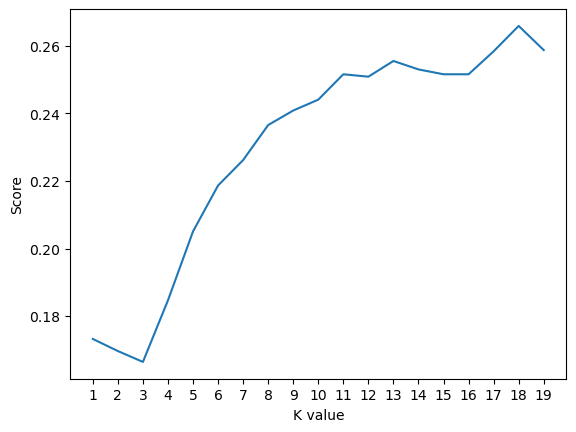

Maximum KNN Score is 26.59%


In [30]:
score_List = []
for i in range(1,20):
    optimal_knn = KNeighborsClassifier(n_neighbors = i) 
    optimal_knn.fit(X_train, y_train)
    score_List.append(optimal_knn.score(X_test, y_test))
    
plt.plot(range(1,20), score_List)
plt.xticks(np.arange(1,20,1))
plt.xlabel("K value")
plt.ylabel("Score")
plt.show()

best_accuracy = max(score_List) * 100

print("Maximum KNN Score is {:.2f}%".format(best_accuracy))

In [31]:
accuracies['KNN'] = best_accuracy

### **7.3 Descision Tree Classifier** 

In [32]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

DecisionTreeClassifier()

In [33]:
Y_pred = clf.predict(X_test)
clf_predictions = [round(value) for value in Y_pred]

# evaluate predictions
clf_accuracy = accuracy_score(y_test, clf_predictions)
accuracies['Decision Tree'] = clf_accuracy * 100.0
print("Accuracy: %.2f%%" % (clf_accuracy * 100.0))

Accuracy: 42.02%


### **7.4 Random Forest Classifier** 

In [34]:
random_forest = RandomForestClassifier(n_estimators = 100, random_state = 42)
random_forest.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [35]:
# make predictions for test data
Y_pred = random_forest.predict(X_test)
rf_predictions = [round(value) for value in Y_pred]

# evaluate predictions
rf_accuracy = accuracy_score(y_test, rf_predictions)
accuracies['Random Forest'] = rf_accuracy * 100.0 
print("Accuracy: %.2f%%" % (rf_accuracy * 100.0))

Accuracy: 40.52%


### **7.5 XG boost Classifier** 

In [36]:
#XG boost Classifier
xgb = XGBClassifier()
xgb.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [37]:
Y_pred = xgb.predict(X_test)
xgb_predictions = [round(value) for value in Y_pred]

# evaluate predictions
xgb_accuracy = accuracy_score(y_test, xgb_predictions)
accuracies['XG Boost'] = xgb_accuracy * 100.0
print("Accuracy: %.2f%%" % (xgb_accuracy * 100.0))

Accuracy: 57.12%


### **7.6 Gradient Descent Classifier** 

In [38]:
sgd = SGDClassifier(max_iter=5, tol=None)
sgd.fit(X_train, y_train)

SGDClassifier(max_iter=5, tol=None)

In [39]:
Y_pred = sgd.predict(X_test)
sgd_predictions = [round(value) for value in Y_pred]

# evaluate predictions
sgd_accuracy = accuracy_score(y_test, sgd_predictions)
accuracies['Gradient Descent'] = sgd_accuracy * 100.0
print("Accuracy: %.2f%%" % (sgd_accuracy * 100.0))

Accuracy: 48.57%


### **7.7 Comparing Algorithms** 

In [40]:
accuracies_pd = pd.DataFrame.from_dict(accuracies, orient='index', columns=['Accuracies(%)'])

In [43]:
accuracies_pd.sort_values(by = 'Accuracies(%)', ascending = False).style.background_gradient(cmap='Blues')

,Accuracies(%)
Logistic Regression,57.193987
XG Boost,57.122405
Gradient Descent,48.568361
Decision Tree,42.018611
Random Forest,40.515390
KNN,26.592699


## **8. Classification across MBTI axis** 

<div style="text-align: justify;"> We intend to add additional columns to represent indicators of personality types. These extra columns will improve the current framework and offer a more profound understanding of the individual's personality traits. </div>

<div style="text-align: justify;"> The following code assigns the value of 1 to the corresponding axis of the Myers-Briggs Type Indicator (MBTI) for Introverted/Extraverted, Intuitive/Sensing, Thinking/Feeling, and Judging/Perceiving. This assignment is based on the presence or absence of the personality traits I, N, T, and J, respectively. Conversely, the value assigned is 0 if the personality traits above are absent. It helps analyze labeled datasets by calculating the number of introverted and extroverted posts. This calculation allows us to explore individual personality indices within the MBTI. </div>

In [46]:
def get_MBTI_types(row):
    t=row['type']

    I = 0; N = 0
    T = 0; J = 0
    
    if t[0] == 'I': I = 1
    elif t[0] == 'E': I = 0
    else: print('I-E not found') 
        
    if t[1] == 'N': N = 1
    elif t[1] == 'S': N = 0
    else: print('N-S not found')
        
    if t[2] == 'T': T = 1
    elif t[2] == 'F': T = 0
    else: print('T-F not found')
        
    if t[3] == 'J': J = 1
    elif t[3] == 'P': J = 0
    else: print('J-P not found')
    return pd.Series( {'IE':I, 'NS':N , 'TF': T, 'JP': J }) 

In [48]:
mbti_data = pd.read_csv("dataset/twitter-mbit.csv")
mbti_data = mbti_data.join(mbti_data.apply (lambda row: get_MBTI_types (row),axis=1))
mbti_data.head(5)

,type,posts,IE,NS,TF,JP
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,1,1,0,1
1,ENTP,'I'm finding the lack of me in these posts ver...,0,1,1,0
2,INTP,'Good one _____ https://www.youtube.com/wat...,1,1,1,0
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",1,1,1,1
4,ENTJ,'You're fired.|||That's another silly misconce...,0,1,1,1


Calculate the ratio of posts in one class to the total number of posts in the other.

In [50]:
print ("Introversion (I) /  Extroversion (E):\t", mbti_data['IE'].value_counts()[0], " / ", mbti_data['IE'].value_counts()[1])
print ("Intuition (N) / Sensing (S):\t\t", mbti_data['NS'].value_counts()[0], " / ", mbti_data['NS'].value_counts()[1])
print ("Thinking (T) / Feeling (F):\t\t", mbti_data['TF'].value_counts()[0], " / ", mbti_data['TF'].value_counts()[1])
print ("Judging (J) / Perceiving (P):\t\t", mbti_data['JP'].value_counts()[0], " / ", mbti_data['JP'].value_counts()[1])

Introversion (I) /  Extroversion (E):	 1999  /  6676
Intuition (N) / Sensing (S):		 1197  /  7478
Thinking (T) / Feeling (F):		 4694  /  3981
Judging (J) / Perceiving (P):		 5241  /  3434


<div style="text-align: justify;"> We noticed that the dataset has an unequal distribution among the four axes. Specifically, most entries fall under the IE: E axis, and most fall under the NS: S axis. On the other hand, there is relatively little difference between the number of entries under the TF and JP axes. </div>

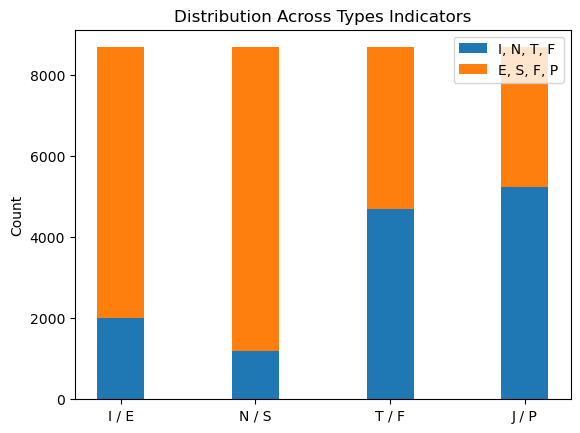

In [51]:
# Calculate the counts for each personality type indicator
counts_0 = [mbti_data[column].value_counts()[0] for column in ['IE', 'NS', 'TF', 'JP']]
counts_1 = [mbti_data[column].value_counts()[1] for column in ['IE', 'NS', 'TF', 'JP']]

# Define the number of bars
N = len(counts_0)

# Define the x locations for the groups
ind = np.arange(N)

# Define the width of the bars
width = 0.35

# Create the bar plot
fig, ax = plt.subplots()
p1 = ax.bar(ind, counts_0, width, label = 'I, N, T, F')
p2 = ax.bar(ind, counts_1, width, bottom = counts_0, label = 'E, S, F, P')

# Add labels, title, and legend
ax.set_title('Distribution Across Types Indicators')
ax.set_ylabel('Count')
ax.set_xticks(ind)
ax.set_xticklabels(('I / E', 'N / S', 'T / F', 'J / P'))
ax.legend()

plt.show()

* The findings align with the outcomes observed in numerous personality and psychological studies carried out by researchers in real-world settings.

* It is estimated that around 16 percent of individuals identify as introverts. Nevertheless, it is essential to acknowledge that significant levels of introverted behavior can be found even among introverts. Renowned psychologist Carl Jung once remarked that individuals cannot be classified as purely extroverted or introverted. Therefore, it may not be easy to classify an individual as one type accurately.

* It is essential to highlight that when it comes to taking a personality test, a large majority, approximately 70%, tend to favor Sensing over Intuition. Intuitionists find themselves in the minority and, therefore, need to adapt to the thinking style of Sensors. It is crucial for individuals to understand and adjust to the preferences of the majority in order to ensure smooth organizational functioning, successful collaborations, and effective communication.

* Judging and Perceiving personality preferences are often considered the most unique among the four preferences. People with a more structured approach may find it challenging to accept those with a more flexible and spontaneous nature and vice versa. Nevertheless, when it comes to a mixed couple consisting of one individual with a Judging preference and another with a Perceiving preference, their contrasting preferences can complement each other as long as they have cultivated the maturity and openness to embrace and appreciate each other's differences. This collaboration could create a powerful alliance that leverages the unique abilities of each person involved.

### **8.1 Data Pre-Processing**

#### **8.1.1 Lemmatization**

In [52]:
lemmatiser = WordNetLemmatizer()

# Remove the stop words for speed 
stopwords = stopwords.words("english")

# Remove these from the posts
unique_type_list = ['INFJ', 'ENTP', 'INTP', 'INTJ', 'ENTJ', 'ENFJ', 'INFP', 'ENFP',
       'ISFP', 'ISTP', 'ISFJ', 'ISTJ', 'ESTP', 'ESFP', 'ESTJ', 'ESFJ']
unique_type_list = [x.lower() for x in unique_type_list]

#### **8.1.2 Binarizing**

In [55]:
b_Pers = {'I': 0, 'E': 1, 'N': 0, 'S': 1, 'F': 0, 'T': 1, 'J': 0, 'P': 1}
b_Pers_list = [{0: 'I', 1: 'E'}, {0: 'N', 1: 'S'}, {0: 'F', 1: 'T'}, {0: 'J', 1: 'P'}]

def translate_personality(personality):
    # Transform MBTI to binary vector
    return [b_Pers[l] for l in personality]

# To show result output for personality prediction
def translate_back(personality):
    # Transform binary vector to MBTI personality
    return ''.join([b_Pers_list[i][l] for i, l in enumerate(personality)])

# List comprehension to binarize MBTI list
list_personality_bin = np.array([translate_personality(p) for p in mbti_data.type])
print("Binarized MBTI list: \n%s" % list_personality_bin)

Binarized MBTI list: 
[[0 0 0 0]
 [1 0 1 1]
 [0 0 1 1]
 ...
 [0 0 1 1]
 [0 0 0 1]
 [0 0 0 1]]


#### **8.1.3 Data Cleaning**

In [60]:
def cleaning_text(data, remove_stop_words=True, remove_mbti_profiles=True):
    list_personality = []
    list_posts = []
    len_data = len(data)
    
    for _, row in data.iterrows():
        # Remove and clean comments
        posts = row.posts

        # Remove URL links
        temp = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ', posts)

        # Remove non-words and extra spaces
        temp = re.sub(r'[^a-zA-Z]', ' ', temp)
        temp = re.sub(r' +', ' ', temp).lower()

        # Remove multiple repeating letters
        temp = re.sub(r'([a-z])\1{2,}[\s|\w]*', '', temp)

        # Remove stop words
        if remove_stop_words:
            temp = " ".join([lemmatiser.lemmatize(w) for w in temp.split() if w not in stopwords])
        else:
            temp = " ".join([lemmatiser.lemmatize(w) for w in temp.split()])

        # Remove MBTI personality words from posts
        if remove_mbti_profiles:
            for t in unique_type_list:
                temp = temp.replace(t, "")

        # Transform MBTI to binary vector
        type_labelized = translate_personality(row.type)
        list_personality.append(type_labelized)
        list_posts.append(temp)

    # Convert lists to numpy arrays
    list_posts = np.array(list_posts)
    list_personality = np.array(list_personality)
    
    return list_posts, list_personality

In [61]:
list_posts, list_personality = cleaning_text(mbti_data, remove_stop_words = True,
                                                 remove_mbti_profiles = True)

### **8.2 Feature Engineering**

#### **8.2.1 tf-idf Vectorizer**

Using count vectorizer and tf-idf vectorizer, we vectorize by keeping words appearing between 10% and 70% of the posts.

In [63]:
# Vectorizing the database posts to a matrix of token counts for the model
cntizer = CountVectorizer(analyzer="word", 
                          max_features=1000,  
                          max_df=0.7,
                          min_df=0.1) 

# Learn the vocabulary dictionary and return term-document matrix
X_cnt = cntizer.fit_transform(list_posts)

# Print feature names
print("Using CountVectorizer:")
print("10 feature names can be seen below")
feature_names = list(cntizer.vocabulary_.keys())
print(feature_names[:10])

# Transform the count matrix to a normalized tf or tf-idf representation
tfizer = TfidfTransformer()

# Learn the idf vector (fit) and transform a count matrix to a tf-idf representation
print("\nUsing Tf-idf:")
X_tfidf = tfizer.fit_transform(X_cnt).toarray()

# Print the dataset size after transformation
print("Now the dataset size is as below:")
print(X_tfidf.shape)

Using CountVectorizer:
10 feature names can be seen below
['moment', 'top', 'play', 'life', 'experience', 'today', 'may', 'last', 'friend', 'posted']

Using Tf-idf:
Now the dataset size is as below:
(8675, 595)


In [64]:
# Counting top 10 words
reverse_dic = {}
for key in cntizer.vocabulary_:
    reverse_dic[cntizer.vocabulary_[key]] = key
top_10_indices = np.asarray(np.argsort(np.sum(X_cnt, axis=0))[0, -10:][0, ::-1]).flatten()
top_10_words = [reverse_dic[idx] for idx in top_10_indices]
print("Top 10 words:")
print(top_10_words)

Top 10 words:
['feel', 'type', 'well', 'say', 'way', 'friend', 'want', 'love', 'good', 'something']


#### **8.2.2 Training & Evaluation Data Split**

Hence, we split the features into 
* X: User Posts in TF-IDF representation and 
* Y: Personality type in Binarized MBTI form.

In [66]:
personality_type = [ "IE: Introversion (I) / Extroversion (E)", "NS: Intuition (N) / Sensing (S)", 
                   "FT: Feeling (F) / Thinking (T)", "JP: Judging (J) / Perceiving (P)"  ]

for l in range(len(personality_type)):
    print(personality_type[l])

IE: Introversion (I) / Extroversion (E)
NS: Intuition (N) / Sensing (S)
FT: Feeling (F) / Thinking (T)
JP: Judging (J) / Perceiving (P)


In [67]:
print("For MBTI personality type : %s" % translate_back(list_personality[0,:]))
print("Y : Binarized MBTI 1st row: %s" % list_personality[0,:])

For MBTI personality type : INFJ
Y : Binarized MBTI 1st row: [0 0 0 0]


In [68]:
X = X_tfidf

### **8.3 Machine Learning Model Training and Evaluation**

In [78]:
def train_and_evaluate_model(model, X, list_personality, personality_type):
    results = []
    for idx, personality_type_label in enumerate(personality_type):
        y = list_personality[:, idx]

        # Split data into train and test sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=7)

        # Fit model on training data
        model.fit(X_train, y_train)

        # Make predictions for test data
        y_pred = model.predict(X_test)

        # Evaluate predictions
        accuracy = accuracy_score(y_test, y_pred)

        results.append([personality_type_label, accuracy])

    return pd.DataFrame(results, columns=["Personality Type", "Accuracy"])

In [79]:
# Define models
models = {
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(),
    "Stochastic Gradient Descent": SGDClassifier(),
    "Logistic Regression": LogisticRegression(),
    "KNeighbors Classifier": KNeighborsClassifier(n_neighbors=2),
    "Decision Tree Classifier": DecisionTreeClassifier()
}

In [80]:
# Create a DataFrame to store results
results_df = pd.DataFrame(columns=["Model", "Personality Type", "Accuracy"])

In [81]:
# Train and evaluate each model
for model_name, model in models.items():
    model_results = train_and_evaluate_model(model, X, list_personality, personality_type)
    model_results["Model"] = model_name
    results_df = pd.concat([results_df, model_results], ignore_index=True)

In [85]:
# Pivot the DataFrame for better visualization
results_pivot = results_df.pivot(index="Model", columns="Personality Type", values="Accuracy")

results_pivot *= 100
results_pivot = results_pivot.round(2)
results_pivot

Personality Type,FT: Feeling (F) / Thinking (T),IE: Introversion (I) / Extroversion (E),JP: Judging (J) / Perceiving (P),NS: Intuition (N) / Sensing (S)
Model,,,,
Decision Tree Classifier,57.84,66.26,54.91,76.67
KNeighbors Classifier,54.70,77.44,39.64,85.82
Logistic Regression,72.44,77.54,64.51,86.06
Random Forest,68.67,77.51,62.10,86.03
Stochastic Gradient Descent,71.88,77.82,63.81,86.03
XGBoost,67.73,76.18,62.87,85.92


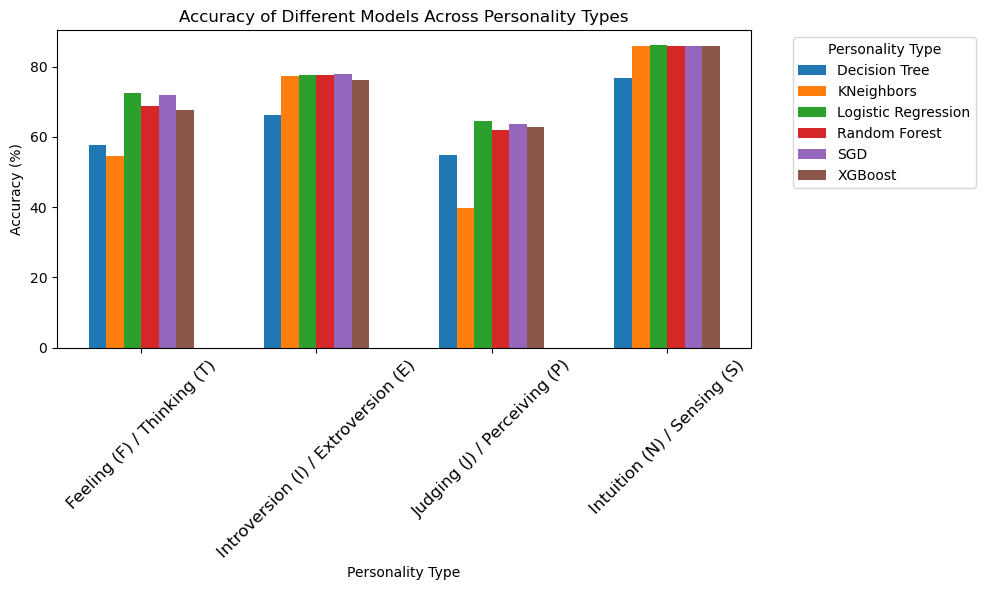

In [175]:
models = ['Decision Tree', 'KNeighbors', 'Logistic Regression', 'Random Forest', 'SGD', 'XGBoost']
personality_types = ['Feeling (F) / Thinking (T)', 'Introversion (I) / Extroversion (E)', 'Judging (J) / Perceiving (P)', 'Intuition (N) / Sensing (S)']
accuracies = [
    [57.84, 66.26, 54.91, 76.67],
    [54.70, 77.44, 39.64, 85.82],
    [72.44, 77.54, 64.51, 86.06],
    [68.67, 77.51, 62.10, 86.03],
    [71.88, 77.82, 63.81, 86.03],
    [67.73, 76.18, 62.87, 85.92]
]

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.1
index = range(len(personality_types))

for i, model in enumerate(models):
    plt.bar([x + i * bar_width for x in index], accuracies[i], bar_width, label=model)

plt.xlabel('Personality Type')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy of Different Models Across Personality Types')
plt.xticks([idx + 0.25 for idx in index], personality_types, rotation = 45, size = 12)
plt.legend(title='Personality Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

* After an extensive review of the models presented above, it is evident that XG Boost showcases impressive performance levels. Due to its exceptional qualities, it has been chosen as the basis for our personality prediction model. This decision is anticipated to produce positive outcomes, as the XGBoost model can accurately assess and provide feedback on the performance of a test set throughout the training process.

* The original gradient boosting papers discussed various configuration strategies. For instance, setting the learning rate in XGBoost to 0.1 or lower is recommended. If smaller values are chosen, more trees may be necessary.

* The optimal tree depth for XGBoost is typically between 2 and 8. Using deeper trees has only produced a slight boost. 

We have experimented with several parameters to enhance the performance of our model in this context.

In [ ]:
# Setup parameter grid for grid search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [2, 3, 4],
    'learning_rate': [0.1, 0.2, 0.3]
}

# Initialize XGBClassifier
model = XGBClassifier(nthread=8)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy')

# Individually train each MBTI personality type
for l in range(len(personality_type)):
    Y = list_personality[:, l]

    # Split data into train and test sets
    seed = 7
    test_size = 0.33
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

    # Perform grid search
    grid_search.fit(X_train, y_train)

    # Get best parameters
    best_params = grid_search.best_params_

    # Initialize XGBClassifier with best parameters
    model = XGBClassifier(**best_params, nthread=8)

    # Fit model on training data
    model.fit(X_train, y_train)

    # Make predictions for test data
    y_pred = model.predict(X_test)

    # Evaluate predictions
    accuracy = accuracy_score(y_test, y_pred)
    print("%s Accuracy: %.2f%%" % (personality_type[l], accuracy * 100.0))

IE: Introversion (I) / Extroversion (E) Accuracy: 77.37%
NS: Intuition (N) / Sensing (S) Accuracy: 86.03%
